# Average wake planes

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil, io
for x in amrwindfedirs: sys.path.insert(1, x)

%matplotlib inline

import postproamrwindsample_xarray as ppsample
import postproengine as ppeng
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

from functools import partial

# Loaded ruamel.yaml


In [3]:
def stringReplaceDict(s, dreplace):
    outstr = str(s)
    for k, g in dreplace.items():
        outstr=outstr.replace(k, g)
    return outstr

In [4]:
def interppoints(xD):
    x = 240*xD
    ptlist = [[x, 0, z] for z in np.linspace(1, 240*2, 240*2)]
    return ptlist

ppeng.interppoints4 = partial(interppoints, 4)
ppeng.interppoints6 = partial(interppoints, 6)
ppeng.interppoints8 = partial(interppoints, 8)
ppeng.interppoints10 = partial(interppoints, 10)

def interpXY(xD):
    x = 240*xD
    ptlist = [[x, y, 150] for y in np.linspace(-240*2, 240*2, 240*4+1)]
    return ptlist

ppeng.interpXY4 = partial(interpXY, 4)
ppeng.interpXY6 = partial(interpXY, 6)
ppeng.interpXY8 = partial(interpXY, 8)
ppeng.interpXY10 = partial(interpXY, 10)

In [5]:
rundir='/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_BD'
RESULTSDIR='../results/'


In [6]:
yamlstring="""
globalattributes:
  verbose: False
  udfmodules: []
  executeorder:
  - avgworkflow
#  - plotstuff

trange: &trange [15300, 15900]

avgworkflow:
  avgplanes:
  - name: XYdomain
    ncfile:
    - RUNDIR/post_processing/XYdomain_090_30000.nc
    tavg: *trange
    #savepklfile:  avg_fixed_hhdomain.pkl         # Name of pickle file to save results (Optional, Default: '')
    #loadpklfile:  avg_fixed_hhdomain.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'NREL5MW ALM AVG horizontal velocity'
      xaxis: x           # Which axis to use on the abscissa 
      yaxis: y           # Which axis to use on the ordinate 
      iplane: [0]
      clevels: np.linspace(0, 14, 141)
      cbar_nticks: 15
  - name: turbHH
    ncfile:
    - RUNDIR/post_processing/turbhh_30000.nc
    tavg: *trange
    #savepklfile:  avg_fixed_hhdomain.pkl         # Name of pickle file to save results (Optional, Default: '')
    #loadpklfile:  avg_fixed_hhdomain.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'NREL5MW ALM AVG horizontal velocity'
      xaxis: a1
      yaxis: a2      
      iplane: [0]
      clevels: np.linspace(0, 14, 141)
      cbar_nticks: 15
  - name: turbSW
    ncfile:
    - RUNDIR/post_processing/turbsw_30000.nc
    tavg: *trange
    #savepklfile:  avg_fixed_hhdomain.pkl         # Name of pickle file to save results (Optional, Default: '')
    #loadpklfile:  avg_fixed_hhdomain.pkl
    #group: T0_YZ_wake2              # Which group to pull from netcdf file (Optional, Default: None)
    contourplot:
      plotfunc: "lambda db: np.sqrt(db['velocityx_avg']**2 + db['velocityy_avg']**2)"
      title: 'NREL5MW ALM AVG horizontal velocity'
      xaxis: a1
      yaxis: a2      
      iplane: [0]
      clevels: np.linspace(0, 14, 141)
      cbar_nticks: 8
      
plotstuff:
  plotcsv:
  - name: plot4
    xlabel: 'U [m/s]'
    ylabel: 'z [m]'
    xscale: linear
    yscale: linear
    title: 'XZ Wake X/D=4'
    figsize: [5,4]
    legendopts: {'loc':'upper right'}
    figname: figXZ
    axesnum: 0
    #postplotfunc: spectrapoints.formatplot
    csvfiles:
    - {'file':'Fixed_XZ_wake_4.csv', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'color':'k', 'lw':1, 'linestyle':'-', 'label':'Fixed'}}
    - {'file':'Floating_XZ_wake_4.csv', 'xcol':'velocityx_avg', 'ycol':'z', 'lineopts':{'color':'r', 'lw':1, 'linestyle':'-', 'label':'Floating'}}


"""
f = io.StringIO(stringReplaceDict(yamlstring, {'RUNDIR':rundir, 'RESULTSDIR':RESULTSDIR}))
yamldict = Loader(f, **loaderkwargs)

Initialized avgplanes
Running avgplanes
/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_BD/post_processing/XYdomain_090_30000.nc 348
[============================================================] 100.0% 
Ncount = 348

Initialized contourplot inside avgplanes
Executing contourplot
/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_BD/post_processing/turbhh_30000.nc 348
[============================================================] 100.0% 
Ncount = 348

Initialized contourplot inside avgplanes
Executing contourplot
/gpfs/lcheung/HFM/exawind-benchmarks/NREL5MW_ALM_BD/post_processing/turbsw_30000.nc 348
[============================================================] 100.0% 
Ncount = 348

Initialized contourplot inside avgplanes
Executing contourplot


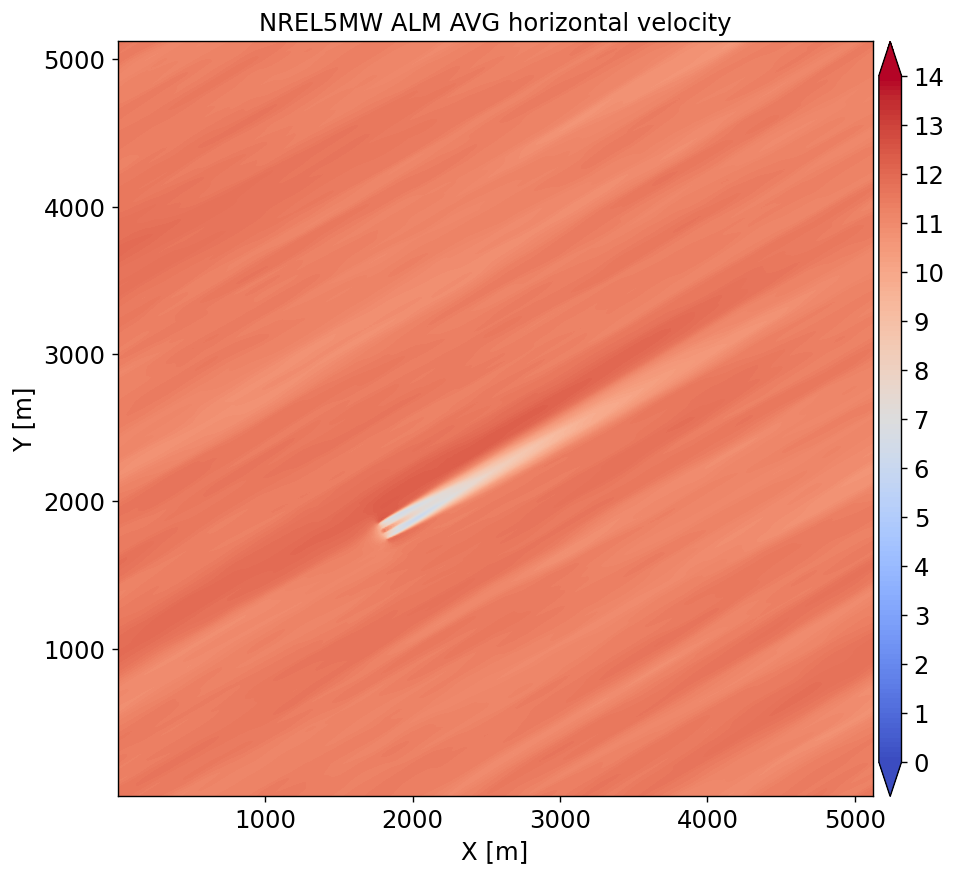

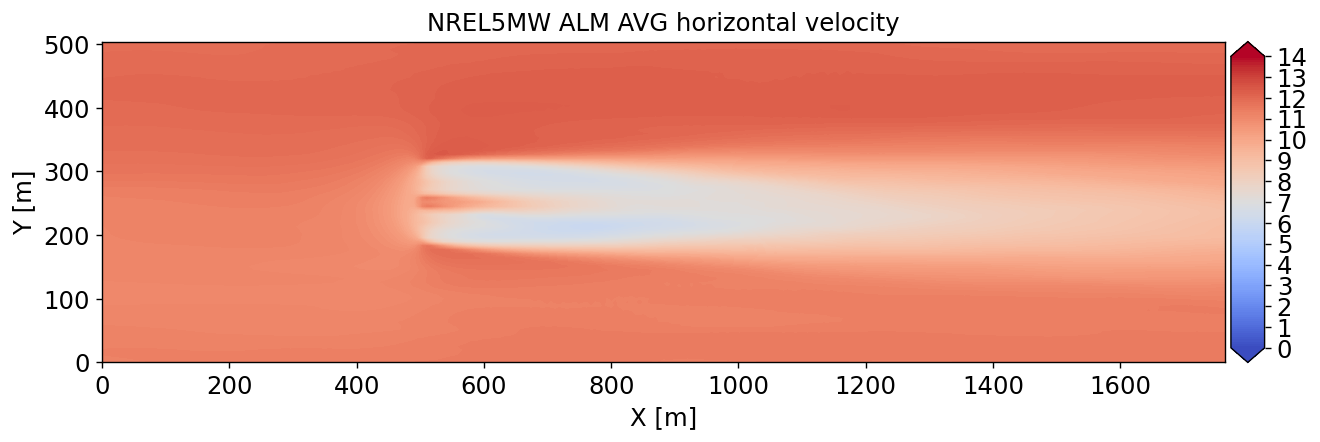

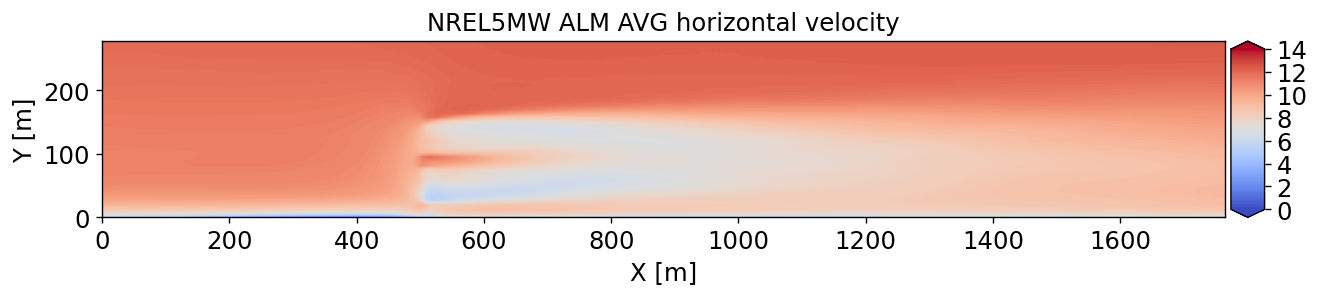

In [7]:
# Run the driver
ppeng.driver(yamldict, verbose=True)